In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

plt.rcParams['font.size'] = 20

In [159]:
loc = 'nw2'
turbine = 'c02'
mode = 'SS2'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
selected_data_little = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_little.csv'))
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
selected_data_large.index = pd.to_datetime(selected_data_large['timestamp'])

smart_tracked_small_training = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_smart_tracked_modes_small_training.csv'))
smart_tracked_large_training = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_smart_tracked_modes_large_training.csv'))
smart_tracked_large_training.index = pd.to_datetime(smart_tracked_large_training['timestamp'])

In [14]:
from src.data.make_dataset import get_reference_based_mode, create_input_data
from src.data.preprocessing import sin_cos_angle_inputs

modal_data = get_reference_based_mode(data_folder, mode, loc, turbine)

input_data = create_input_data(data_folder, loc, turbine)
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]
selected_input_data = input_data[selected_columns]

In [18]:
import pickle
models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, 'catboost_model_large.pkl')
with open(model_path, 'rb') as file:
    regr_model = pickle.load(file)

In [252]:
# Full model predictions
predictions = regr_model.predict(selected_input_data)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=selected_input_data.index)

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(selected_input_data, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge_uncertainty', 'data_uncertainty'], index=selected_input_data.index)

# uncertainty = knowledge_uncertainty + data_uncertainty
uncertainty_ = virtual_ensemble_preds_df['knowledge_uncertainty']
uncertainty_moving_avg = pd.Series(virtual_ensemble_preds_df['knowledge_uncertainty'], index=selected_input_data.index).rolling(4*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[selected_data_large.index].quantile(0.83)

prediction_lim = predictions_df['prediction'].loc[selected_data_large.index].std()*2
prediction_lim

0.02619906447084002

In [253]:
from src.smart_tracking.smart_tracking import smart_tracking

smart_tracked = smart_tracking(
    modal_data['frequency'],
    predictions_df['prediction'],
    uncertainty_moving_avg,
    uncertainty_lim,
    prediction_lim
    )

C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2005810888.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_selected_input_data = selected_input_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2005810888.py:8: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_modal_data = modal_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2005810888.py:9: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

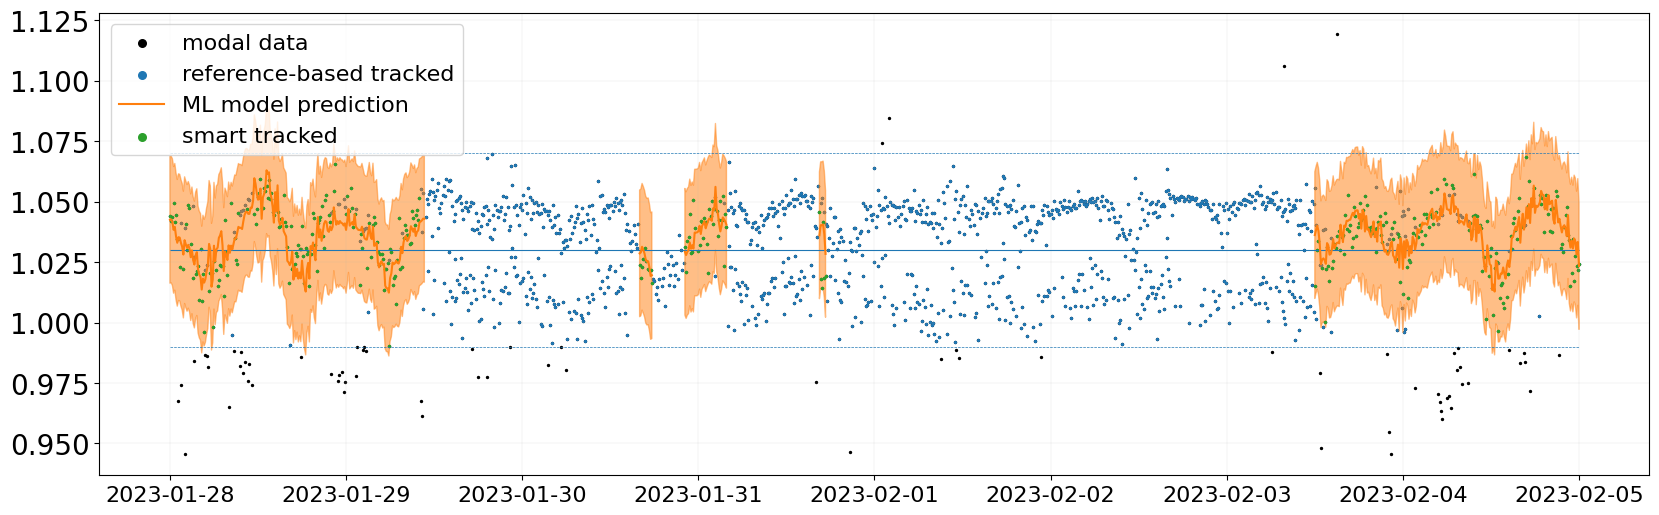

C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2005810888.py:46: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2005810888.py:48: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge_uncertainty'], s=1, c='r')


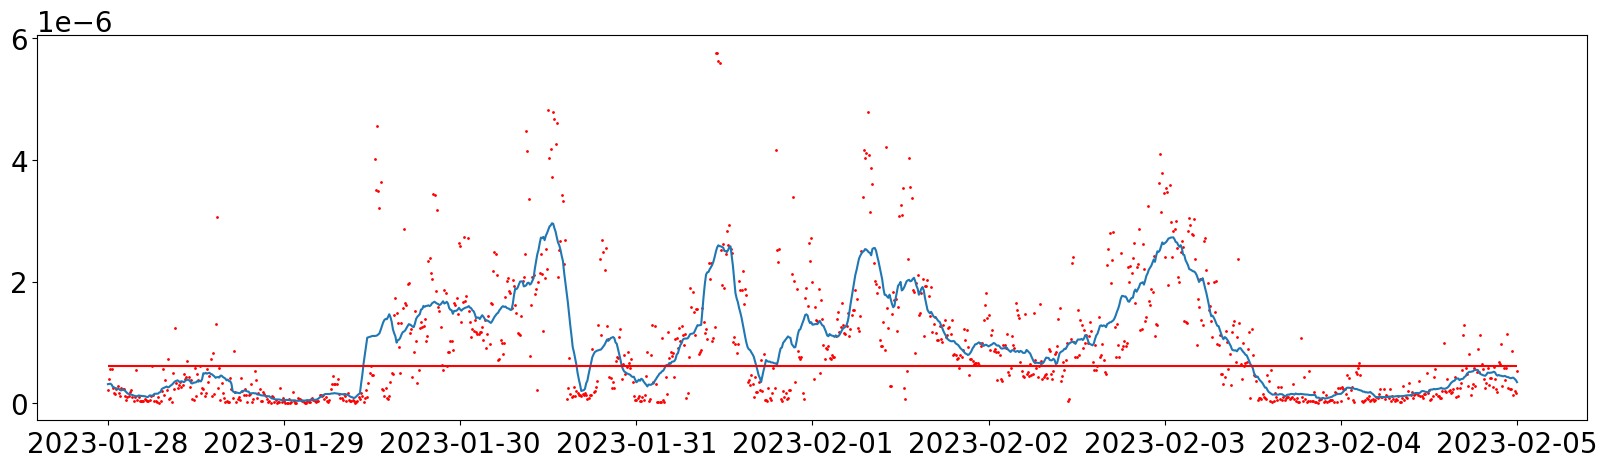

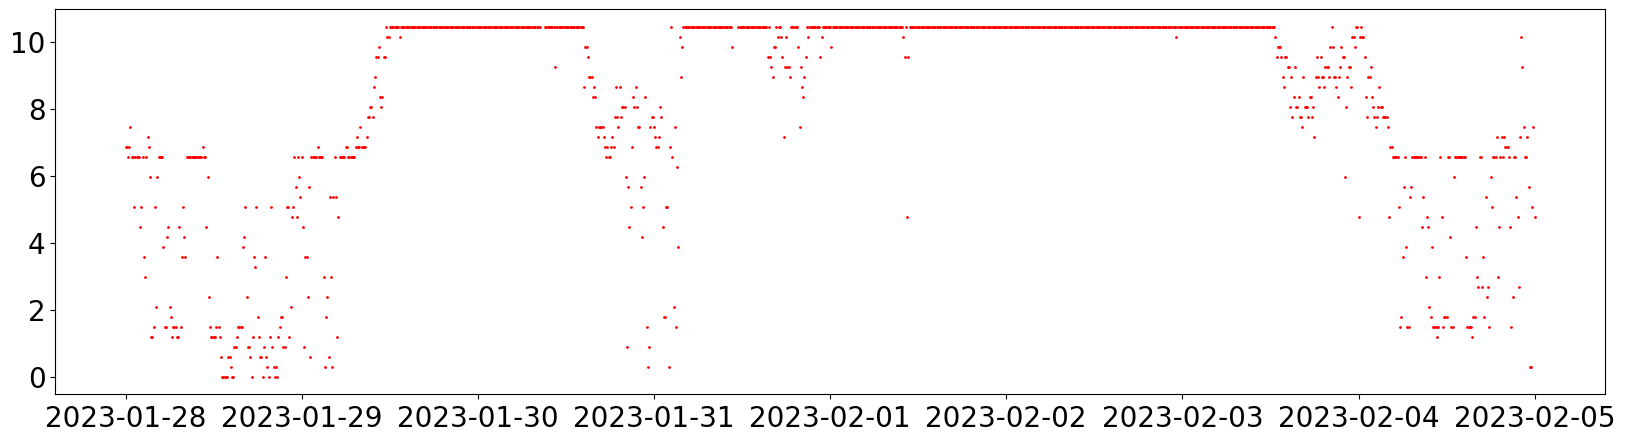

In [254]:
analyzed_timeframe = (
    datetime.datetime(2023, 1, 28),
    datetime.datetime(2023, 2, 5)
)


plt_selected_input_data = selected_input_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = modal_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
plt_predictions_low_uncertainty.resample('10M')
plt_smart_tracked = smart_tracked.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data['frequency'] > lower_ref) & (plt_modal_data['frequency'] < upper_ref)]

plt.figure(figsize=(20, 6))
plt.scatter(plt_modal_data.index, plt_modal_data['frequency'], color='k', s=2, label='modal data')
plt.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
plt.scatter(reference_tracked.index, reference_tracked['frequency'], color='tab:blue', s=2, label='reference-based tracked')
#plt.plot(plt_predictions['prediction'])
#plt.scatter(plt_predictions.index, plt_predictions['prediction'], color='tab:orange', s=1)
#plt.scatter(plt_predictions_low_uncertainty.index, plt_predictions_low_uncertainty['prediction'], color='tab:blue', s=10)
plt.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
plt.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.5, color='tab:orange')

plt.scatter(plt_smart_tracked.index, plt_smart_tracked['frequency'], color='tab:green', s=2, label='smart tracked')
legend = plt.legend(loc='upper left', fontsize=16)
for handles in legend.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
plt.xticks(fontsize=16)
plt.grid(linewidth=0.1)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
plt.hlines(uncertainty_lim, analyzed_timeframe[0], analyzed_timeframe[1], color='r')
plt.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge_uncertainty'], s=1, c='r')
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(plt_selected_input_data.index, plt_selected_input_data['mean_NW2_C02_rpm'], s=1, c='r')
plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_27264\1527047339.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_selected_input_data = selected_input_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\1527047339.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_modal_data = modal_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\1527047339.py:8: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

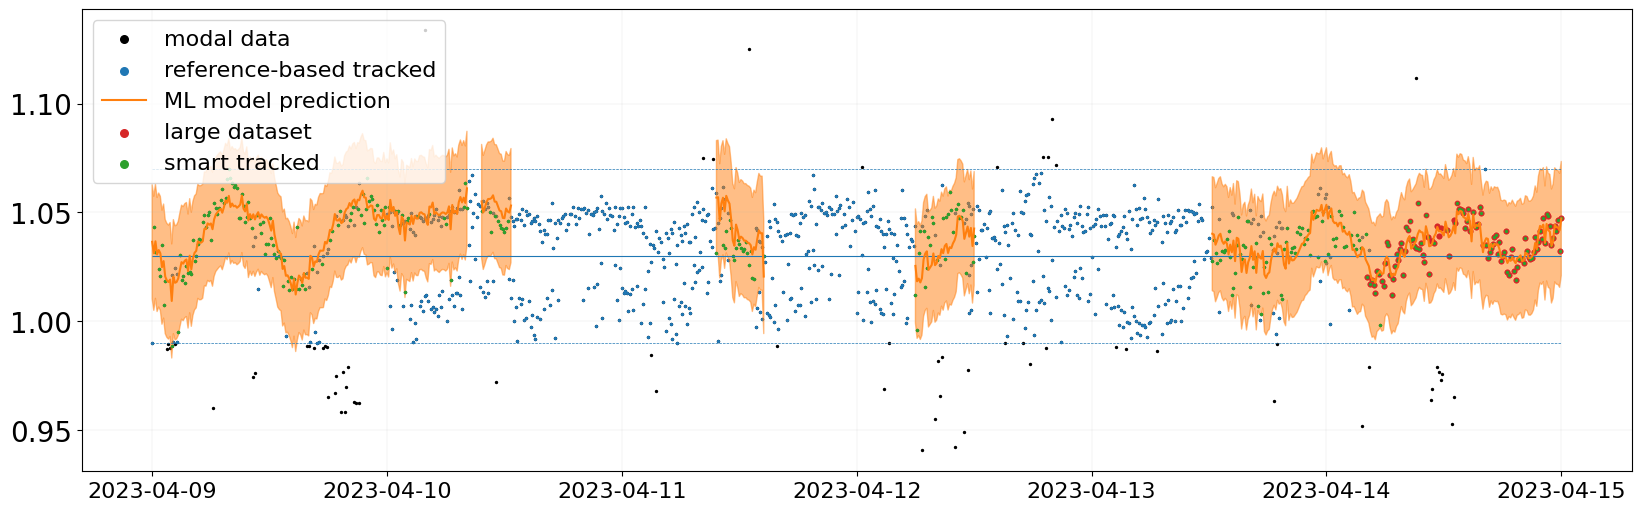

In [255]:
analyzed_timeframe = (
    datetime.datetime(2023, 4, 9),
    datetime.datetime(2023, 4, 15)
)

plt_selected_input_data = selected_input_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = modal_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
plt_predictions_low_uncertainty.resample('10M')
plt_smart_tracked = smart_tracked.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

plt_selected_data_large_index = selected_data_large.index.intersection(plt_selected_input_data.index)
plt_selected_large = selected_data_large.loc[plt_selected_data_large_index]

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data['frequency'] > lower_ref) & (plt_modal_data['frequency'] < upper_ref)]

plt.figure(figsize=(20, 6))
plt.scatter(plt_modal_data.index, plt_modal_data['frequency'], color='k', s=2, label='modal data')
plt.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
plt.scatter(reference_tracked.index, reference_tracked['frequency'], color='tab:blue', s=2, label='reference-based tracked')
#plt.plot(plt_predictions['prediction'])
#plt.scatter(plt_predictions.index, plt_predictions['prediction'], color='tab:orange', s=1)
#plt.scatter(plt_predictions_low_uncertainty.index, plt_predictions_low_uncertainty['prediction'], color='tab:blue', s=10)
plt.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
plt.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.5, color='tab:orange')
plt.scatter(plt_selected_large.index, plt_selected_large['mean_frequency'], color='tab:red', s=10, label='large dataset')
plt.scatter(plt_smart_tracked.index, plt_smart_tracked['frequency'], color='tab:green', s=2, label='smart tracked')
legend = plt.legend(loc='upper left', fontsize=16)
for handles in legend.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
plt.xticks(fontsize=16)
plt.grid(linewidth=0.1)
plt.show()
plt.close()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'mean_NW2_C02_rpm'),
  Text(1, 0, 'mean_NW2_C02_pitch'),
  Text(2, 0, 'mean_NW2_C02_power'),
  Text(3, 0, 'mean_NW2_C02_windspeed'),
  Text(4, 0, 'sin_mean_NW2_C02_yaw'),
  Text(5, 0, 'cos_mean_NW2_C02_yaw'),
  Text(6, 0, 'sin_mean_NW2_C02_winddirection'),
  Text(7, 0, 'cos_mean_NW2_C02_winddirection'),
  Text(8, 0, 'mvbc_WandelaarBuoy_Wave_height'),
  Text(9, 0, 'mvbc_WandelaarBuoy_Average_wave_period'),
  Text(10, 0, 'mvbc_WandelaarMeasuringpile_Tide_TAW'),
  Text(11, 0, 'mvbc_WandelaarMeasuringpile_Air_pressure'),
  Text(12, 0, 'mvbc_WandelaarMeasuringpile_Air_temperature')])

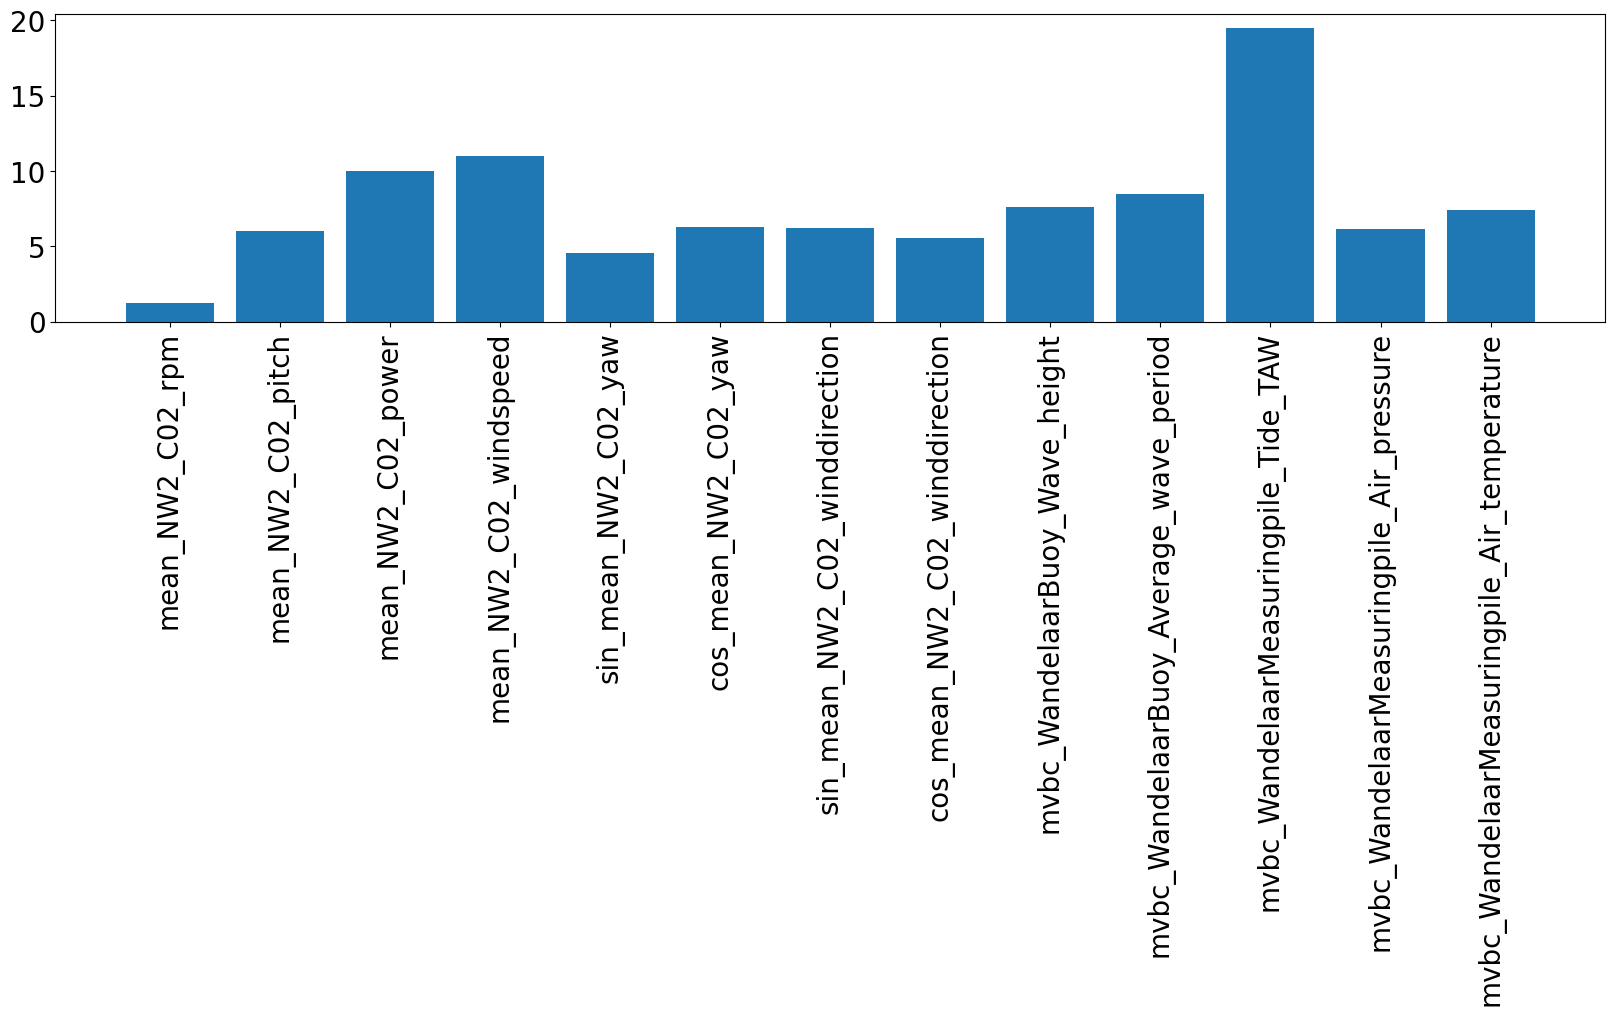

In [256]:
plt.figure(figsize=(20,4))
plt.bar(selected_columns, regr_model.get_feature_importance())
plt.xticks(rotation=90)

mean_NW2_C02_rpm


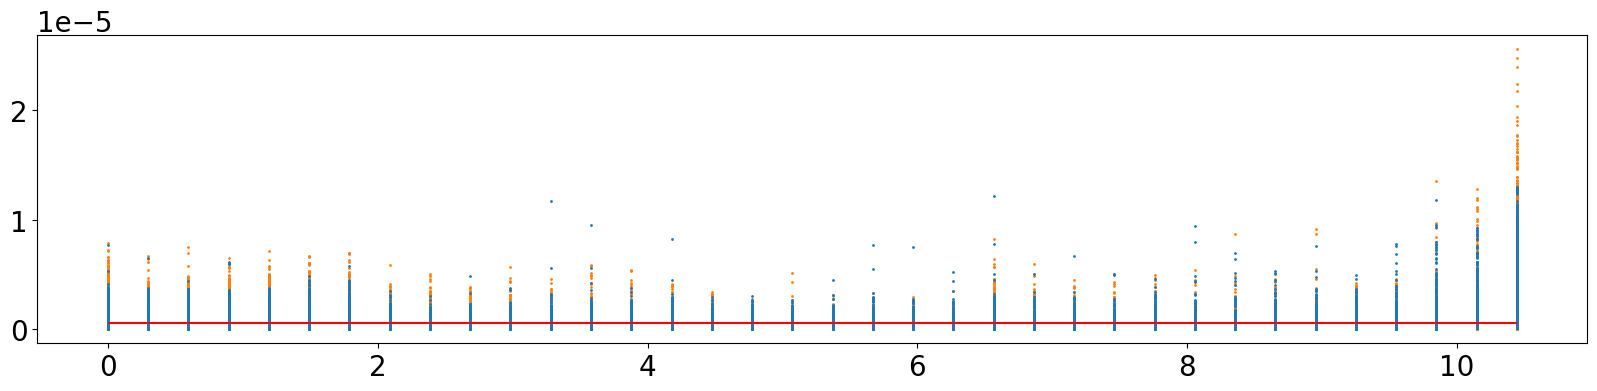

mean_NW2_C02_pitch


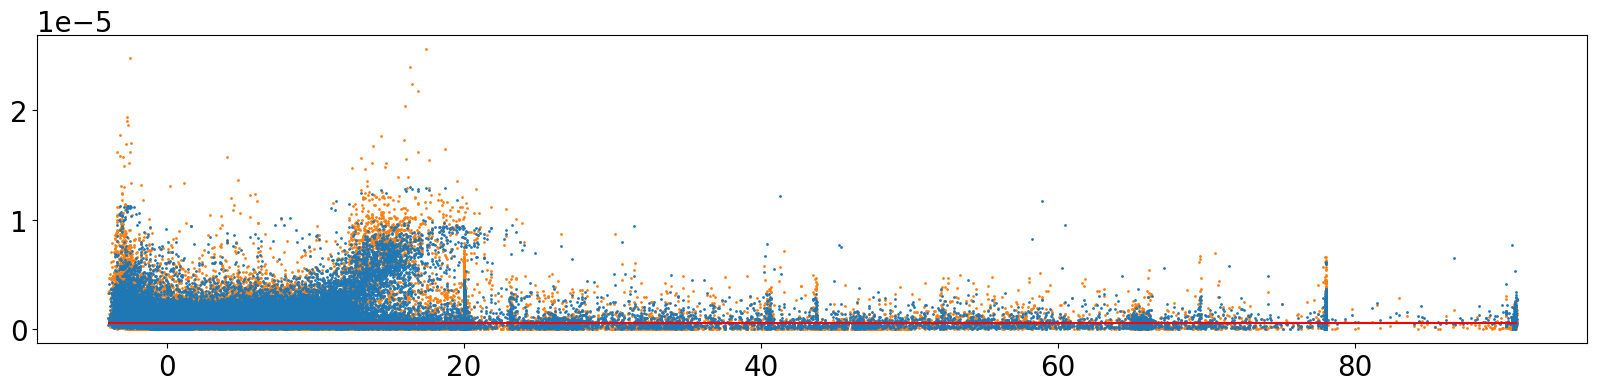

mean_NW2_C02_power


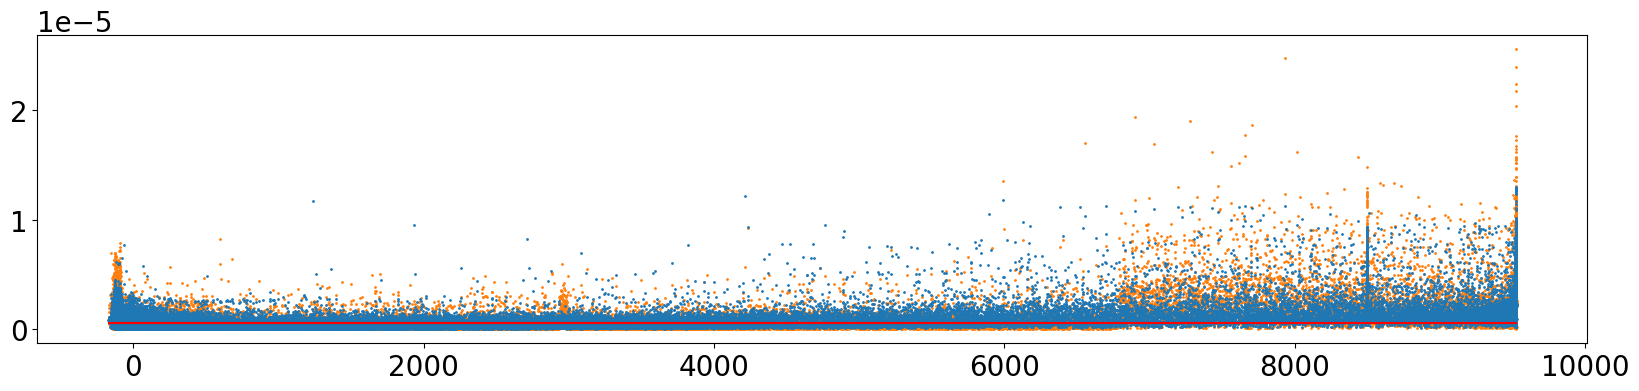

mean_NW2_C02_windspeed


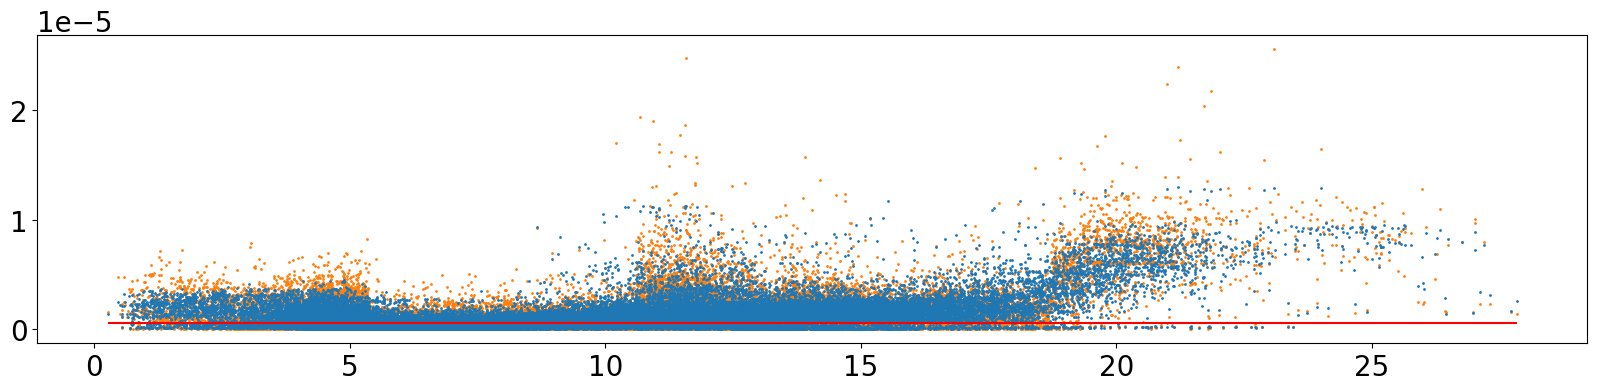

sin_mean_NW2_C02_yaw


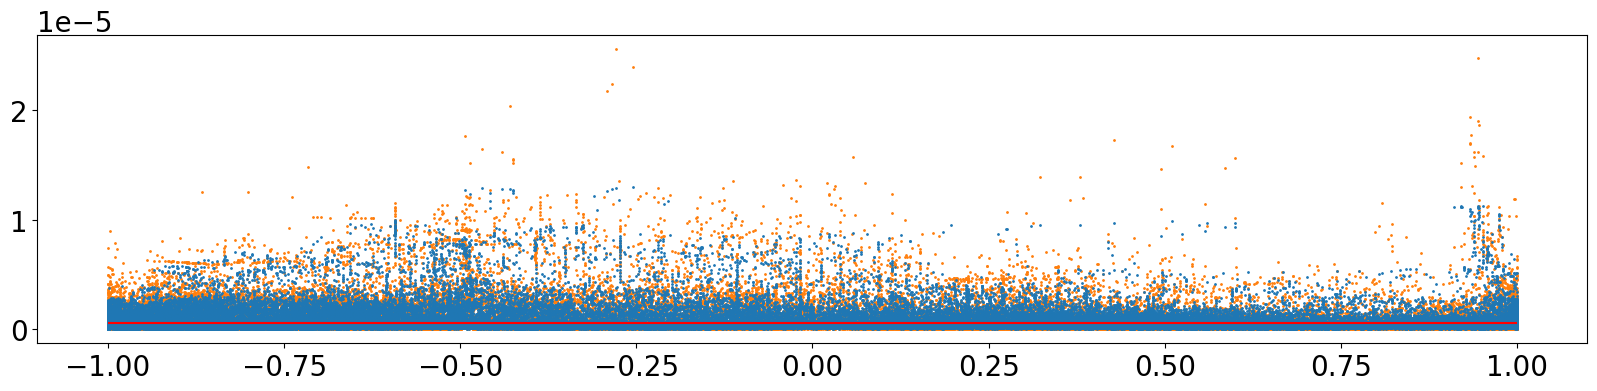

cos_mean_NW2_C02_yaw


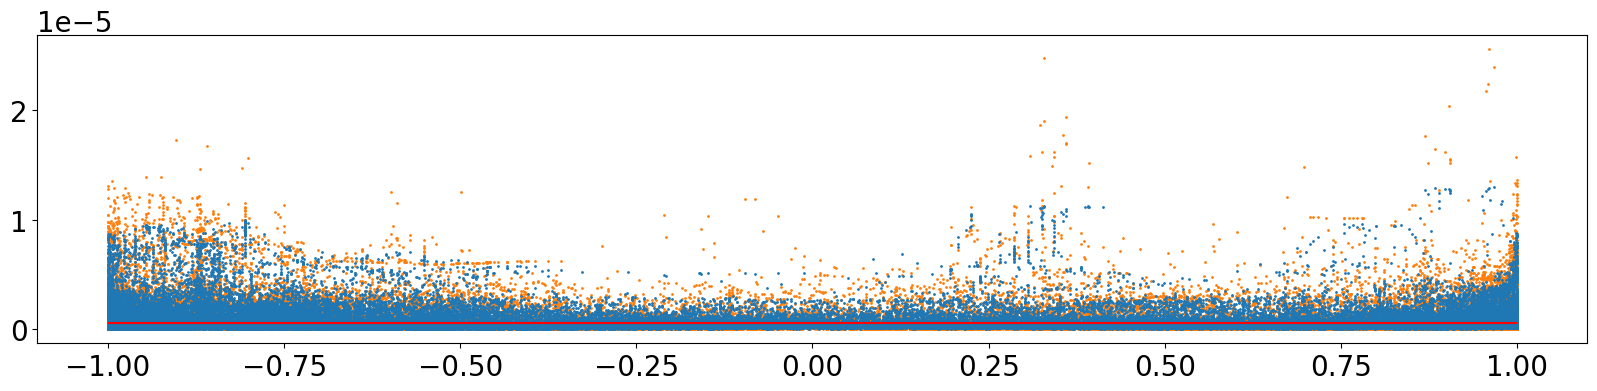

sin_mean_NW2_C02_winddirection


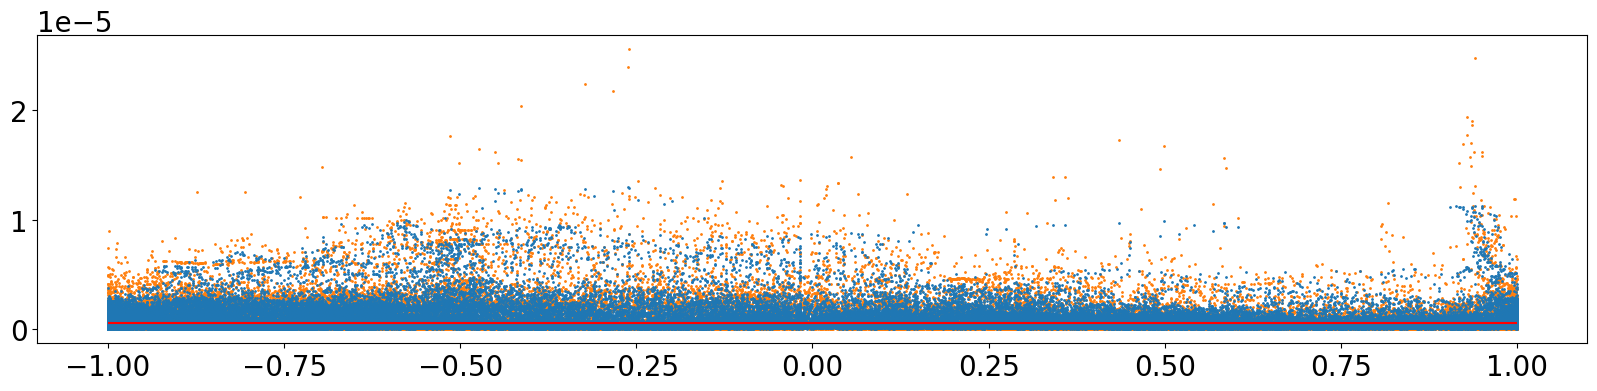

cos_mean_NW2_C02_winddirection


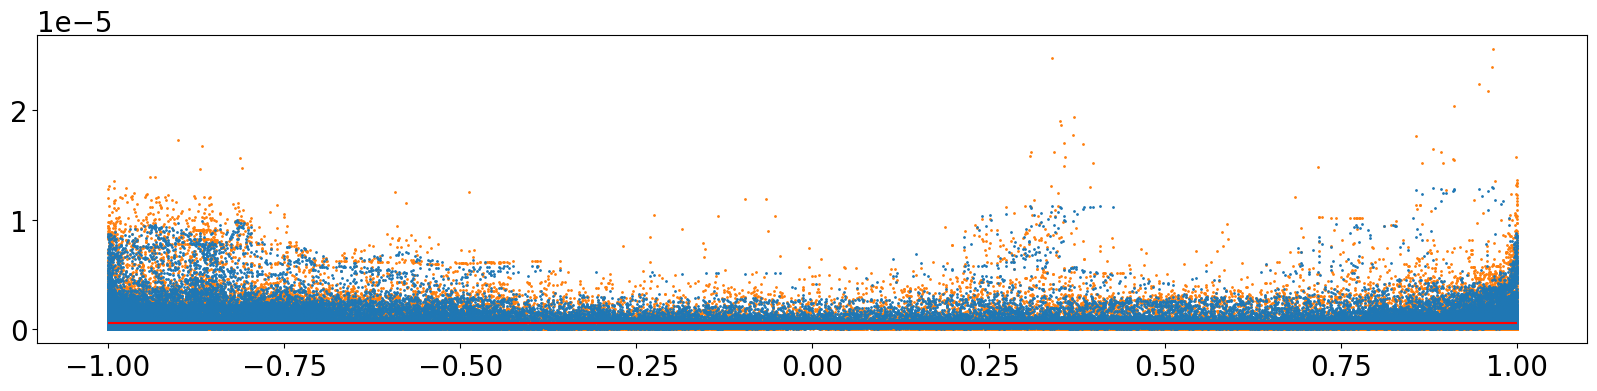

mvbc_WandelaarBuoy_Wave_height


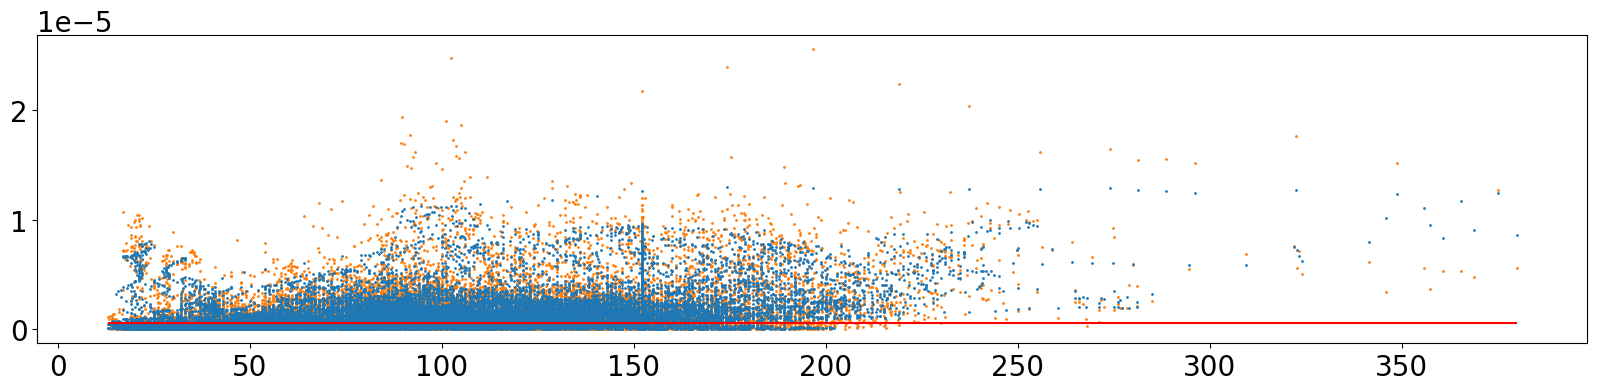

mvbc_WandelaarBuoy_Average_wave_period


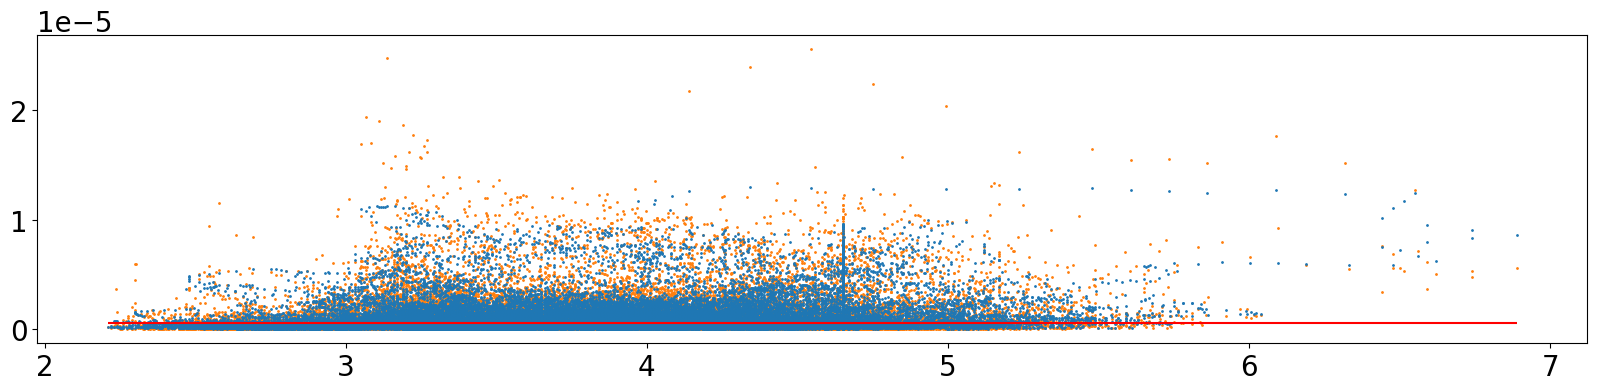

mvbc_WandelaarMeasuringpile_Tide_TAW


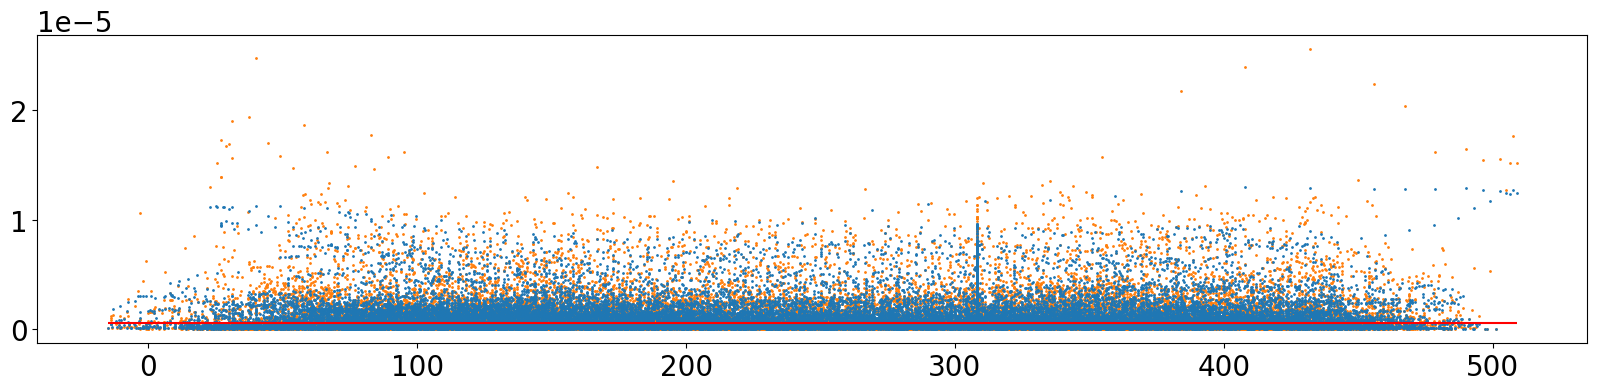

mvbc_WandelaarMeasuringpile_Air_pressure


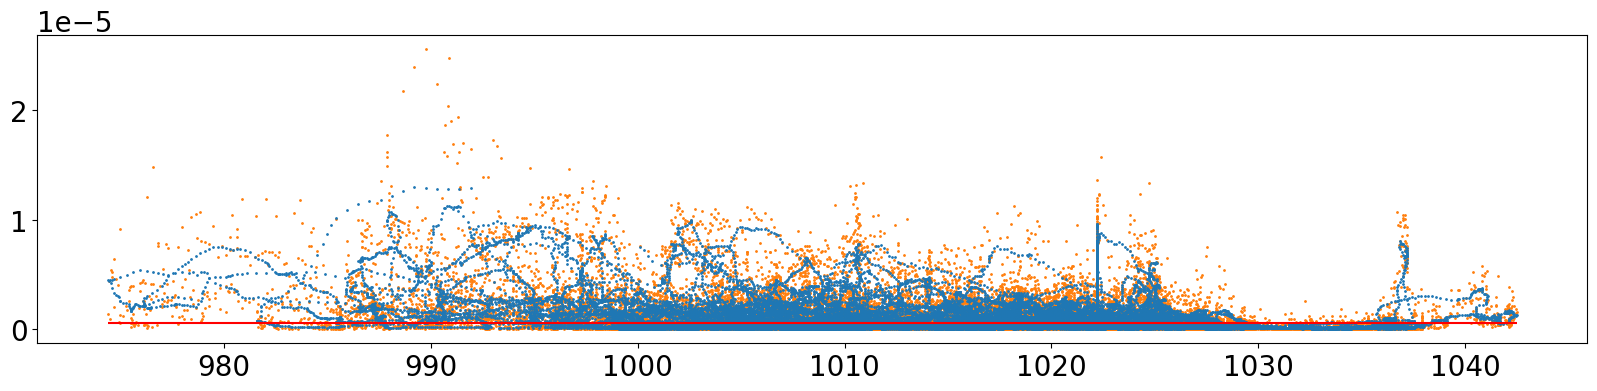

mvbc_WandelaarMeasuringpile_Air_temperature


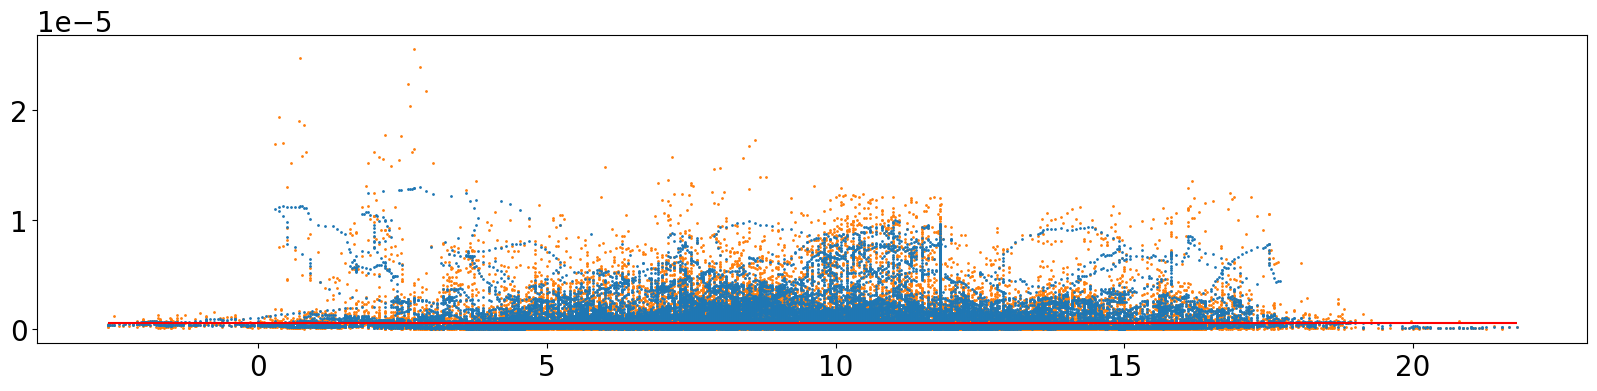

In [257]:
for col in selected_input_data.columns:
    print(col)
    plt.figure(figsize=(20,4))
    plt.hlines(uncertainty_lim, selected_input_data[col].min(), selected_input_data[col].max(), color='r')
    plt.scatter(selected_input_data[col], uncertainty_,s=1, c='tab:orange')
    plt.scatter(selected_input_data[col], uncertainty_moving_avg,s=1, c='tab:blue')

    plt.show()
    plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2226314458.py:9: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_selected_input_data = selected_input_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2226314458.py:10: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_modal_data = modal_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2226314458.py:11: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1

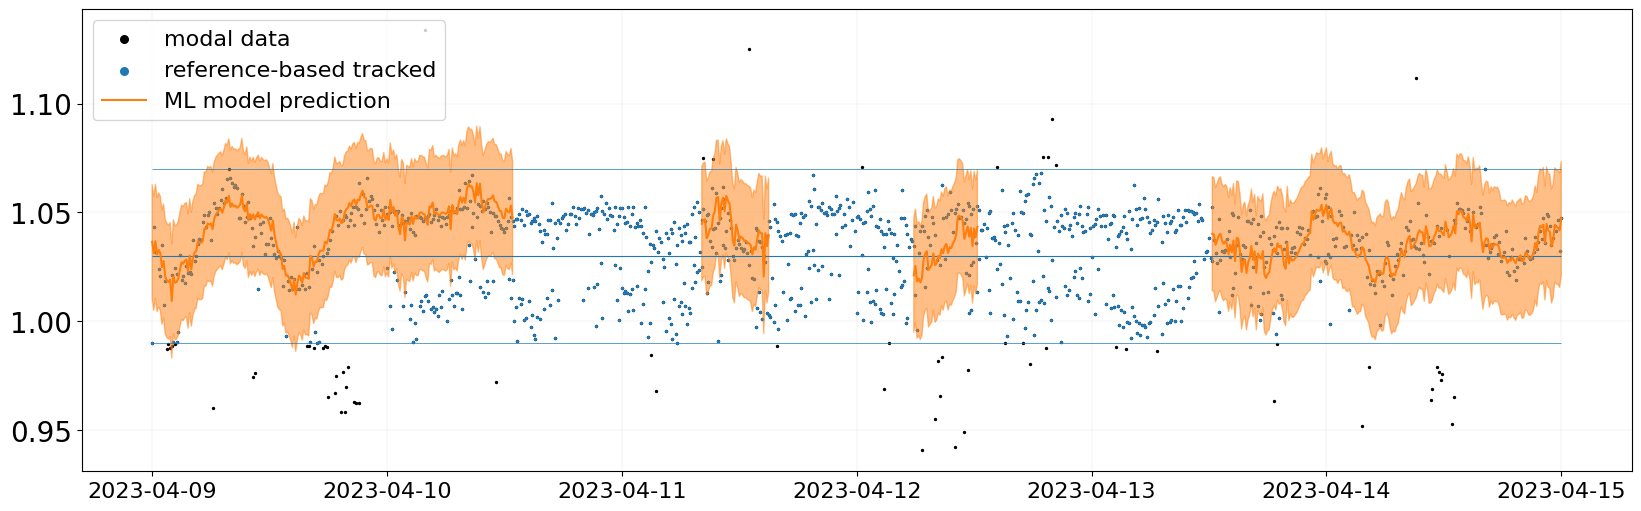

C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2226314458.py:45: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
C:\Users\Max\AppData\Local\Temp\ipykernel_27264\2226314458.py:47: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  plt.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge_uncertainty'], s=1, c='r')


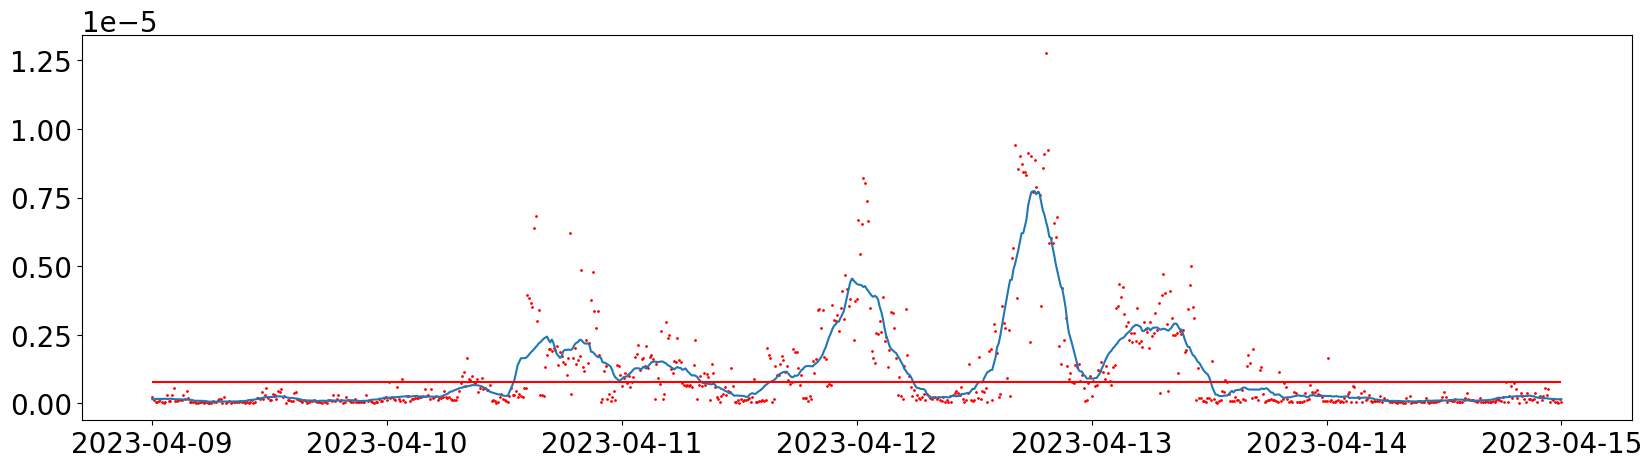

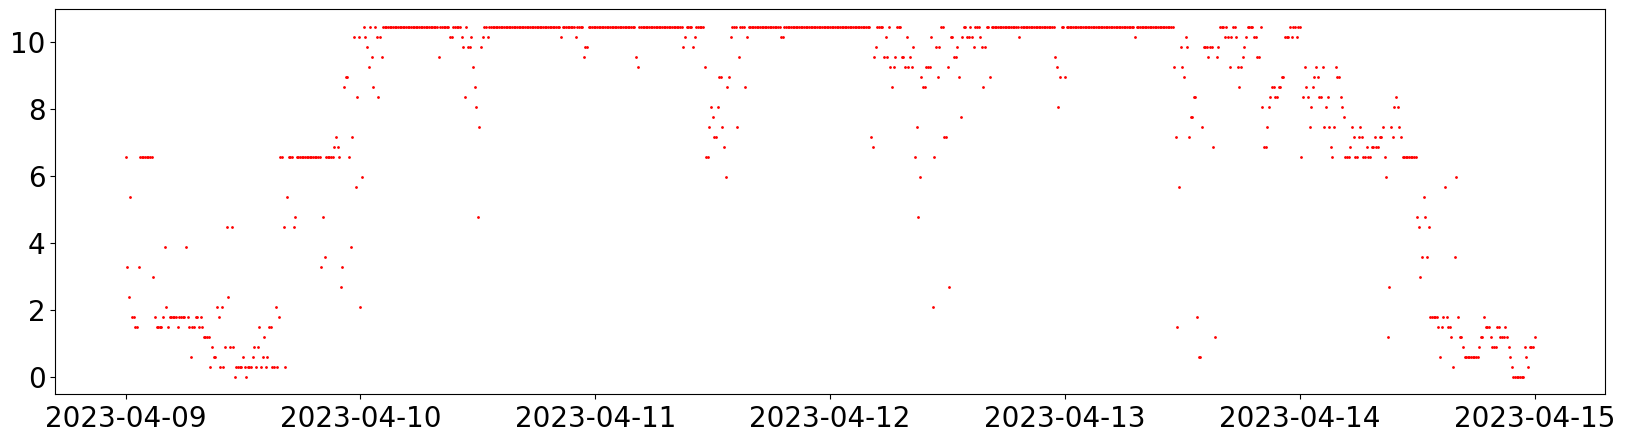

In [258]:
analyzed_timeframe = (
    datetime.datetime(2023, 4, 9),
    datetime.datetime(2023, 4, 15)
)

uncertainty_lim = uncertainty_.loc[selected_data_large.index].quantile(0.85)

prediction_lim = predictions_df['prediction'].loc[selected_data_large.index].std()*2
plt_selected_input_data = selected_input_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = modal_data.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
plt_predictions_low_uncertainty.resample('10M')

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data['frequency'] > lower_ref) & (plt_modal_data['frequency'] < upper_ref)]

plt.figure(figsize=(20, 6))
plt.scatter(plt_modal_data.index, plt_modal_data['frequency'], color='k', s=2, label='modal data')
plt.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5)
plt.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5)
plt.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
plt.scatter(reference_tracked.index, reference_tracked['frequency'], color='tab:blue', s=2, label='reference-based tracked')
#plt.plot(plt_predictions['prediction'])
#plt.scatter(plt_predictions.index, plt_predictions['prediction'], color='tab:orange', s=1)
#plt.scatter(plt_predictions_low_uncertainty.index, plt_predictions_low_uncertainty['prediction'], color='tab:blue', s=10)
plt.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
plt.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.5, color='tab:orange')
legend = plt.legend(loc='upper left', fontsize=16)
for handles in legend.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
plt.xticks(fontsize=16)
plt.grid(linewidth=0.1)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
plt.hlines(uncertainty_lim, analyzed_timeframe[0], analyzed_timeframe[1], color='r')
plt.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge_uncertainty'], s=1, c='r')
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(plt_selected_input_data.index, plt_selected_input_data['mean_NW2_C02_rpm'], s=1, c='r')
plt.show()
plt.close()

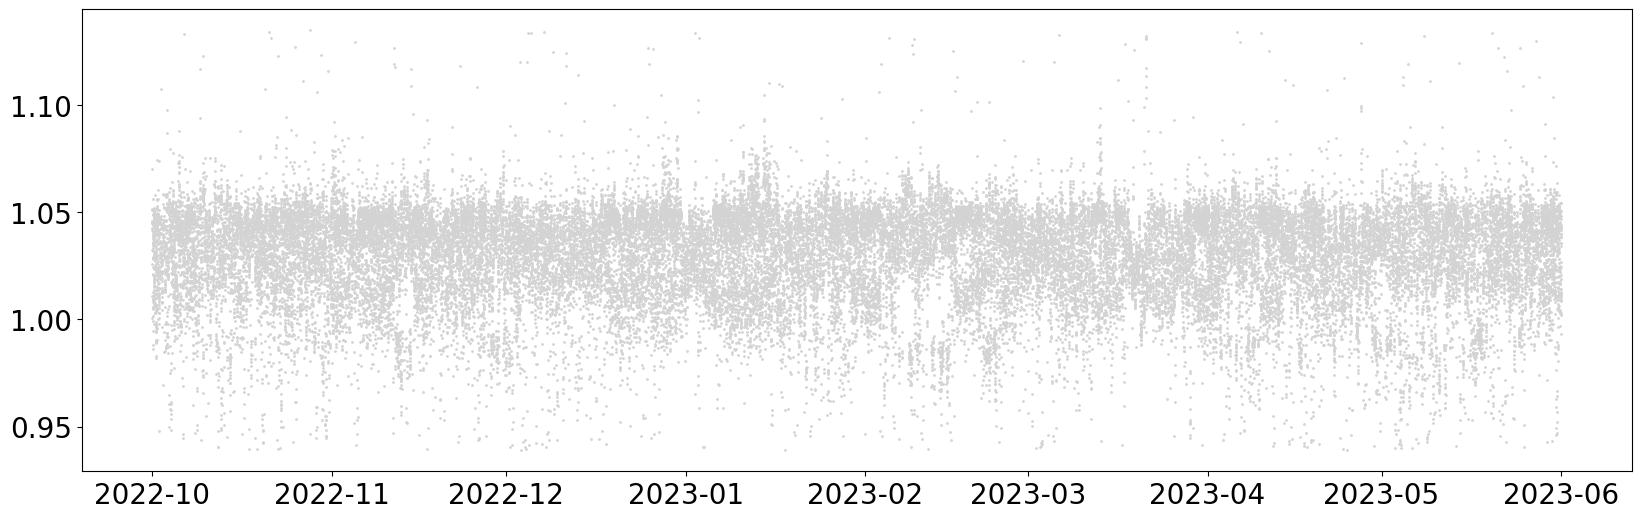

In [259]:
plt.figure(figsize=(20, 6))
plt.scatter(modal_data.index, modal_data['frequency'], color='lightgrey', s=1)
plt.show()
plt.close()